# 04 — Ingredient Constraint Filtering
### CSC 577 | Team Rocket | Food.com Recipe Recommender

This notebook takes the top-N candidate recipes produced by both CF models and applies an **ingredient availability constraint layer** on top.

**Two constraint modes:**
- **Hard constraint** — only recommend recipes where the user has ALL ingredients
- **Soft constraint** — allow recipes with up to `max_missing` ingredients missing (re-rank by missing count)

**Inputs:**
- `data/processed/cf_ubased_candidates.csv`
- `data/processed/cf_svd_candidates.csv`
- `data/processed/recipes_clean.csv`

**Outputs:**
- `data/processed/constrained_ubcf_hard.csv`
- `data/processed/constrained_ubcf_soft.csv`
- `data/processed/constrained_svd_hard.csv`
- `data/processed/constrained_svd_soft.csv`

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import os

os.makedirs('../data/processed', exist_ok=True)
print('Libraries loaded.')

Libraries loaded.


## 1. Load Data

In [2]:
recipes    = pd.read_csv('../data/processed/recipes_clean.csv')
ubcf_cands = pd.read_csv('../data/processed/cf_ubased_candidates.csv')
svd_cands  = pd.read_csv('../data/processed/cf_svd_candidates.csv')

print(f'Recipes:         {len(recipes):,}')
print(f'UB-CF candidates: {len(ubcf_cands):,}')
print(f'SVD candidates:   {len(svd_cands):,}')

recipes.head(2)

Recipes:         36,756
UB-CF candidates: 181,740
SVD candidates:   181,740


,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,description,ingredients,n_ingredients,calories,total_fat_pdv,sugar_pdv,sodium_pdv,protein_pdv,sat_fat_pdv,carbs_pdv
0,chicken lickin good pork chops,63986,500,14664,2003-06-06,weeknight|time-to-make|course|main-ingredient|...,5,here's and old standby i enjoy from time to ti...,lean pork chops|flour|salt|dry mustard|garlic ...,7,105.7,8.0,0.0,26.0,5.0,4.0,3.0
1,chile rellenos,43026,45,52268,2002-10-14,60-minutes-or-less|time-to-make|course|main-in...,9,a favorite from a local restaurant no longer i...,egg roll wrap|whole green chilies|cheese|corns...,5,94.0,10.0,0.0,11.0,11.0,21.0,0.0


## 2. Parse Ingredients

In preprocessing we saved ingredients as pipe-separated strings (e.g. `"flour|sugar|eggs"`). Parse them back into sets for fast lookup.

In [3]:
# Parse pipe-separated ingredient strings into frozensets (hashable, fast intersection)
recipes['ingredient_set'] = recipes['ingredients'].apply(
    lambda x: frozenset(i.strip().lower() for i in x.split('|')) if isinstance(x, str) else frozenset()
)

# Build a lookup dict: recipe_id -> ingredient_set
recipe_ingredients = dict(zip(recipes['recipe_id'], recipes['ingredient_set']))

print(f'Ingredient lookup built for {len(recipe_ingredients):,} recipes.')
# Show an example
sample_id = recipes['recipe_id'].iloc[0]
print(f'\nExample — recipe_id {sample_id}:')
print(recipe_ingredients[sample_id])

Ingredient lookup built for 36,756 recipes.

Example — recipe_id 63986:
frozenset({'flour', 'salt', 'lean pork chops', 'chicken rice soup', 'dry mustard', 'oil', 'garlic powder'})


## 3. Define the User's Available Ingredients

In a real system this would come from user input at query time. For this project we simulate it in two ways:

1. **Demo mode** — a hardcoded pantry for a single example user (to illustrate the system)
2. **Batch simulation mode** — for each user, randomly sample a subset of ingredients from their historically rated recipes (simulates a realistic pantry)

Batch mode is used for generating the evaluation files.

In [4]:
# ── DEMO: single user example ──────────────────────────────────────────
DEMO_PANTRY = frozenset([
    'salt', 'pepper', 'olive oil', 'garlic', 'onion',
    'butter', 'flour', 'sugar', 'eggs', 'milk',
    'chicken breast', 'tomatoes', 'lemon juice', 'parsley'
])

print(f'Demo pantry has {len(DEMO_PANTRY)} ingredients:')
print(sorted(DEMO_PANTRY))

Demo pantry has 14 ingredients:
['butter', 'chicken breast', 'eggs', 'flour', 'garlic', 'lemon juice', 'milk', 'olive oil', 'onion', 'parsley', 'pepper', 'salt', 'sugar', 'tomatoes']


In [5]:
def simulate_user_pantry(user_id, interactions_df, recipe_ingredients, coverage=0.7, seed=42):
    """
    Simulate a user's available ingredients by pooling all ingredients from
    recipes they have rated, then randomly keeping `coverage` fraction of them.

    This models a realistic pantry — users tend to have ingredients they
    already cook with regularly.
    """
    rng = np.random.default_rng(seed + hash(user_id) % 10000)

    # Get all recipes this user has rated
    user_recipes = interactions_df[interactions_df['user_id'] == user_id]['recipe_id'].unique()

    # Pool all ingredients from those recipes
    all_ings = set()
    for rid in user_recipes:
        if rid in recipe_ingredients:
            all_ings.update(recipe_ingredients[rid])

    if not all_ings:
        return frozenset()

    # Randomly keep `coverage` fraction
    all_ings_list = list(all_ings)
    n_keep = max(1, int(len(all_ings_list) * coverage))
    kept = rng.choice(all_ings_list, size=n_keep, replace=False)
    return frozenset(kept)


print('simulate_user_pantry() defined.')

simulate_user_pantry() defined.


## 4. Constraint Filtering Functions

Two modes applied to a candidate list for a single user:

In [6]:
def count_missing(recipe_id, user_pantry, recipe_ingredients):
    """Return the number of ingredients in the recipe not in the user's pantry."""
    if recipe_id not in recipe_ingredients:
        return np.inf   # unknown recipe — treat as not satisfiable
    return len(recipe_ingredients[recipe_id] - user_pantry)


def apply_hard_constraint(candidates_df, user_pantry, recipe_ingredients):
    """
    Hard constraint: keep only recipes where ALL ingredients are available.
    Preserves the original CF ranking order.
    """
    candidates_df = candidates_df.copy()
    candidates_df['n_missing'] = candidates_df['recipe_id'].apply(
        lambda rid: count_missing(rid, user_pantry, recipe_ingredients)
    )
    filtered = candidates_df[candidates_df['n_missing'] == 0].copy()
    filtered['rank'] = range(1, len(filtered) + 1)
    return filtered


def apply_soft_constraint(candidates_df, user_pantry, recipe_ingredients, max_missing=3):
    """
    Soft constraint: keep recipes with <= max_missing ingredients missing.
    Re-ranks by (n_missing ASC, predicted_rating DESC) — feasibility first,
    then preference within each feasibility tier.
    """
    candidates_df = candidates_df.copy()
    candidates_df['n_missing'] = candidates_df['recipe_id'].apply(
        lambda rid: count_missing(rid, user_pantry, recipe_ingredients)
    )
    filtered = candidates_df[candidates_df['n_missing'] <= max_missing].copy()
    filtered = filtered.sort_values(
        ['n_missing', 'predicted_rating'],
        ascending=[True, False]
    )
    filtered['rank'] = range(1, len(filtered) + 1)
    return filtered


print('Constraint functions defined.')

Constraint functions defined.


## 5. Demo — Single User

Show the filtering in action for one user before running the full batch.

In [7]:
# Pick the first user in the SVD candidates
demo_user = svd_cands['user_id'].iloc[0]
demo_cands = svd_cands[svd_cands['user_id'] == demo_user].copy()

print(f'Demo user: {demo_user}')
print(f'Candidate recipes: {len(demo_cands)}')
print(f'\nPantry ({len(DEMO_PANTRY)} items): {sorted(DEMO_PANTRY)}')

# Show candidate recipes with their ingredient lists
demo_merged = demo_cands.merge(recipes[['recipe_id', 'name', 'ingredients', 'ingredient_set']], on='recipe_id', how='left')
demo_merged['n_missing'] = demo_merged['recipe_id'].apply(
    lambda rid: count_missing(rid, DEMO_PANTRY, recipe_ingredients)
)
print('\nCandidates + missing ingredient counts:')
demo_merged[['rank', 'recipe_id', 'name', 'predicted_rating', 'n_missing']].head(20)

Demo user: 1533
Candidate recipes: 20

Pantry (14 items): ['butter', 'chicken breast', 'eggs', 'flour', 'garlic', 'lemon juice', 'milk', 'olive oil', 'onion', 'parsley', 'pepper', 'salt', 'sugar', 'tomatoes']

Candidates + missing ingredient counts:


,rank,recipe_id,name,predicted_rating,n_missing
0,1,54257,yes virginia there is a great meatloaf,4.8556,10
1,2,81853,easy crock pot macaroni and cheese,4.8450,4
2,3,75302,mrs geraldine s ground beef casserole,4.8429,11
3,4,87782,greek potatoes oven roasted and delicious,4.8415,7
4,5,63689,my family s favorite sloppy joes pizza joes,4.8406,10
5,6,150863,panera s cream cheese potato soup,4.8392,6
6,7,62236,chocolate cottage cheese,4.8388,2
7,8,50806,green chile chicken,4.8388,6
8,9,83268,3 packet roast,4.8387,6
9,10,37336,melt in your mouth chicken breasts,4.8387,6


In [8]:
# Hard constraint
hard_demo = apply_hard_constraint(demo_cands, DEMO_PANTRY, recipe_ingredients)
hard_demo = hard_demo.merge(recipes[['recipe_id', 'name']], on='recipe_id', how='left')

print(f'=== HARD CONSTRAINT (0 missing) ===')
print(f'Recipes surviving: {len(hard_demo)} out of {len(demo_cands)}')
print(hard_demo[['rank', 'name', 'predicted_rating', 'n_missing']].to_string(index=False))

=== HARD CONSTRAINT (0 missing) ===
Recipes surviving: 0 out of 20
Empty DataFrame
Columns: [rank, name, predicted_rating, n_missing]
Index: []


In [9]:
# Soft constraint (allow up to 3 missing)
soft_demo = apply_soft_constraint(demo_cands, DEMO_PANTRY, recipe_ingredients, max_missing=3)
soft_demo = soft_demo.merge(recipes[['recipe_id', 'name']], on='recipe_id', how='left')

print(f'=== SOFT CONSTRAINT (≤ 3 missing) ===')
print(f'Recipes surviving: {len(soft_demo)} out of {len(demo_cands)}')
print(soft_demo[['rank', 'name', 'predicted_rating', 'n_missing']].to_string(index=False))

=== SOFT CONSTRAINT (≤ 3 missing) ===
Recipes surviving: 6 out of 20
 rank                                   name  predicted_rating  n_missing
    1               chocolate cottage cheese            4.8388          2
    2           bisquick sour cream biscuits            4.8384          2
    3                        root beer float            4.8381          2
    4                            24k carrots            4.8383          3
    5 dill pickle ham pinwheels  ham rollups            4.8380          3
    6               perfect basic white rice            4.8379          3


## 6. Batch Processing — All Users

Apply both constraint modes to both CF models for all users. We simulate each user's pantry using `simulate_user_pantry()`.

In [10]:
# Load interactions for pantry simulation
interactions = pd.read_csv('../data/processed/interactions_clean.csv')

MAX_MISSING = 3   # soft constraint threshold

def process_all_users(candidates_df, interactions_df, recipe_ingredients,
                      max_missing=3, coverage=0.7):
    """
    For each user in candidates_df:
      1. Simulate their pantry
      2. Apply hard and soft constraints
    Returns two DataFrames: (hard_results, soft_results)
    """
    hard_rows, soft_rows = [], []
    users = candidates_df['user_id'].unique()

    for i, user_id in enumerate(users):
        if i % 500 == 0:
            print(f'  Processing user {i}/{len(users)}...')

        user_cands = candidates_df[candidates_df['user_id'] == user_id]

        # Simulate pantry
        pantry = simulate_user_pantry(
            user_id, interactions_df, recipe_ingredients, coverage=coverage
        )

        # Hard constraint
        hard = apply_hard_constraint(user_cands, pantry, recipe_ingredients)
        hard['user_id'] = user_id
        hard_rows.append(hard)

        # Soft constraint
        soft = apply_soft_constraint(user_cands, pantry, recipe_ingredients, max_missing)
        soft['user_id'] = user_id
        soft_rows.append(soft)

    hard_df = pd.concat(hard_rows, ignore_index=True) if hard_rows else pd.DataFrame()
    soft_df = pd.concat(soft_rows, ignore_index=True) if soft_rows else pd.DataFrame()
    return hard_df, soft_df


print('process_all_users() defined.')

process_all_users() defined.


In [11]:
print('=== Processing UB-CF candidates ===')
ubcf_hard, ubcf_soft = process_all_users(
    ubcf_cands, interactions, recipe_ingredients, MAX_MISSING
)
print(f'UB-CF hard: {len(ubcf_hard):,} rows | UB-CF soft: {len(ubcf_soft):,} rows')

print('\n=== Processing SVD candidates ===')
svd_hard, svd_soft = process_all_users(
    svd_cands, interactions, recipe_ingredients, MAX_MISSING
)
print(f'SVD hard:   {len(svd_hard):,} rows | SVD soft:   {len(svd_soft):,} rows')

=== Processing UB-CF candidates ===
  Processing user 0/9087...
  Processing user 500/9087...
  Processing user 1000/9087...
  Processing user 1500/9087...
  Processing user 2000/9087...
  Processing user 2500/9087...
  Processing user 3000/9087...
  Processing user 3500/9087...
  Processing user 4000/9087...
  Processing user 4500/9087...
  Processing user 5000/9087...
  Processing user 5500/9087...
  Processing user 6000/9087...
  Processing user 6500/9087...
  Processing user 7000/9087...
  Processing user 7500/9087...
  Processing user 8000/9087...
  Processing user 8500/9087...
  Processing user 9000/9087...
UB-CF hard: 597 rows | UB-CF soft: 33,371 rows

=== Processing SVD candidates ===
  Processing user 0/9087...
  Processing user 500/9087...
  Processing user 1000/9087...
  Processing user 1500/9087...
  Processing user 2000/9087...
  Processing user 2500/9087...
  Processing user 3000/9087...
  Processing user 3500/9087...
  Processing user 4000/9087...
  Processing user 4500

## 7. Constraint Satisfaction Rate (Preview)

What fraction of CF candidates survive the ingredient filter? This is one of our key evaluation metrics.

=== Constraint Satisfaction Rate Preview ===
     Model  Surviving  Total  CSR (%)
UB-CF Hard        597 181740     0.33
UB-CF Soft      33371 181740    18.36
  SVD Hard       1445 181740     0.80
  SVD Soft      52222 181740    28.73


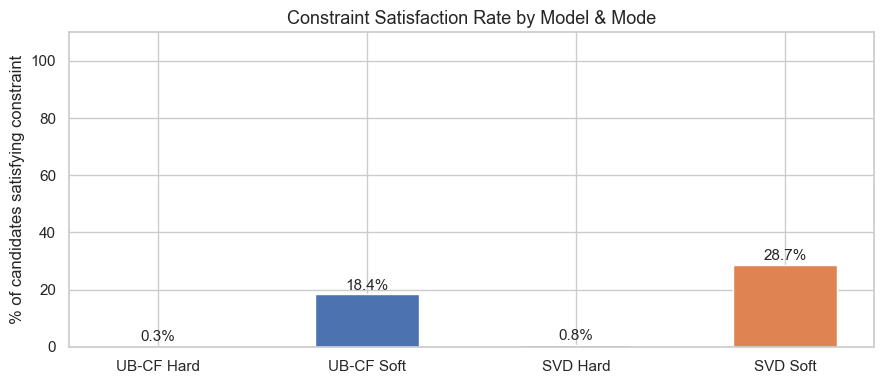

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

total_ubcf = len(ubcf_cands)
total_svd  = len(svd_cands)

csr_data = {
    'Model':      ['UB-CF Hard', 'UB-CF Soft', 'SVD Hard', 'SVD Soft'],
    'Surviving':  [len(ubcf_hard), len(ubcf_soft), len(svd_hard), len(svd_soft)],
    'Total':      [total_ubcf,     total_ubcf,     total_svd,     total_svd],
}
csr_df = pd.DataFrame(csr_data)
csr_df['CSR (%)'] = (csr_df['Surviving'] / csr_df['Total'] * 100).round(2)

print('=== Constraint Satisfaction Rate Preview ===')
print(csr_df.to_string(index=False))

# Bar chart
plt.figure(figsize=(9, 4))
colors = ['#4C72B0', '#4C72B0', '#DD8452', '#DD8452']
bars = plt.bar(csr_df['Model'], csr_df['CSR (%)'], color=colors, edgecolor='white', width=0.5)
for bar, val in zip(bars, csr_df['CSR (%)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=11)
plt.title('Constraint Satisfaction Rate by Model & Mode', fontsize=13)
plt.ylabel('% of candidates satisfying constraint')
plt.ylim(0, 110)
plt.tight_layout()
plt.savefig('../results/constraint_satisfaction_rate.png', bbox_inches='tight')
plt.show()

## 8. Distribution of Missing Ingredients (Soft Results)

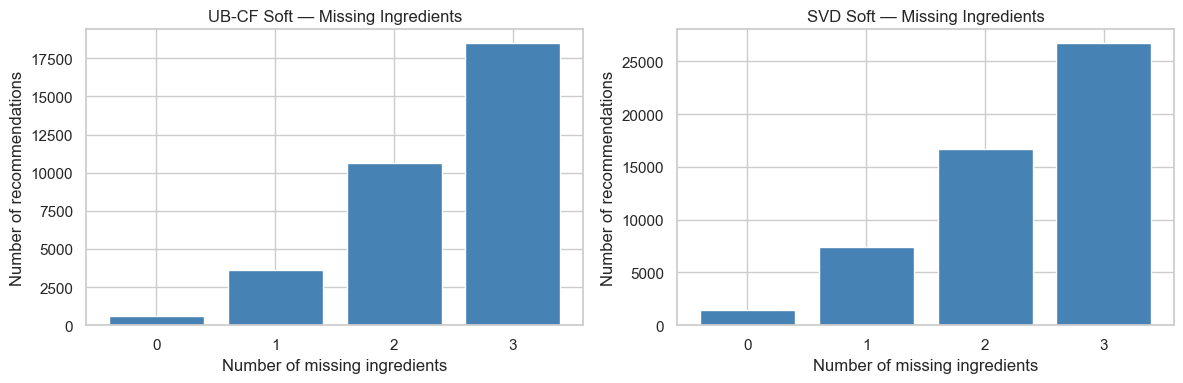

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, df, title in [
    (axes[0], ubcf_soft, 'UB-CF Soft — Missing Ingredients'),
    (axes[1], svd_soft,  'SVD Soft — Missing Ingredients')
]:
    counts = df['n_missing'].value_counts().sort_index()
    ax.bar(counts.index, counts.values, color='steelblue', edgecolor='white')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Number of missing ingredients')
    ax.set_ylabel('Number of recommendations')
    ax.set_xticks(range(int(df['n_missing'].max()) + 1))

plt.tight_layout()
plt.savefig('../results/missing_ingredient_distribution.png', bbox_inches='tight')
plt.show()

## 9. Save All Constrained Outputs

In [14]:
cols = ['user_id', 'recipe_id', 'predicted_rating', 'rank', 'n_missing']

ubcf_hard[cols].to_csv('../data/processed/constrained_ubcf_hard.csv', index=False)
ubcf_soft[cols].to_csv('../data/processed/constrained_ubcf_soft.csv', index=False)
svd_hard[cols].to_csv('../data/processed/constrained_svd_hard.csv',  index=False)
svd_soft[cols].to_csv('../data/processed/constrained_svd_soft.csv',  index=False)

print('Saved:')
print(f'  constrained_ubcf_hard.csv — {len(ubcf_hard):,} rows')
print(f'  constrained_ubcf_soft.csv — {len(ubcf_soft):,} rows')
print(f'  constrained_svd_hard.csv  — {len(svd_hard):,} rows')
print(f'  constrained_svd_soft.csv  — {len(svd_soft):,} rows')

Saved:
  constrained_ubcf_hard.csv — 597 rows
  constrained_ubcf_soft.csv — 33,371 rows
  constrained_svd_hard.csv  — 1,445 rows
  constrained_svd_soft.csv  — 52,222 rows


## Summary

| Output file | Description |
|---|---|
| `constrained_ubcf_hard.csv` | UB-CF candidates with 0 missing ingredients |
| `constrained_ubcf_soft.csv` | UB-CF candidates with ≤ 3 missing, re-ranked by feasibility |
| `constrained_svd_hard.csv`  | SVD candidates with 0 missing ingredients |
| `constrained_svd_soft.csv`  | SVD candidates with ≤ 3 missing, re-ranked by feasibility |

**Re-ranking logic (soft mode):** sort by `(n_missing ASC, predicted_rating DESC)` — the most makeable recipes come first, and within equal feasibility the CF preference score breaks the tie.